In [1]:
from analysis_package import *

from typing import Tuple, Optional, List, Dict
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import euclidean
from random import choice

import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

data_path = 'Z:\\data\\240626\\M07484\\Network\\000041\\data.raw.h5'
plts_path = 'C:\\Users\\evank\\iCloudDrive\\Desktop\\HALnalysis_summer_2024_data\\plots\\240626.M07484.WELL4'
chip_div_well = 'M07484 | DIV33 | WELL4'

well_no = 4
recording_no = 0
voltage_threshold = None

print(data_path)
print(plts_path)
print(well_no)
print(chip_div_well)

Z:\data\240626\M07484\Network\000041\data.raw.h5
C:\Users\evank\iCloudDrive\Desktop\HALnalysis_summer_2024_data\plots\240626.M07484.WELL4
4
M07484 | DIV33 | WELL4


In [2]:
def load_data(path: str, well_no: int, recording_no: int, voltage_threshold: Optional[float]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    spikes = load_spikes_from_file(path, well_no, recording_no, voltage_threshold)
    with h5py.File(path, "r") as h5_file:
        mapping_h5 = h5_file['wells'][f'well{well_no:0>3}'][f'rec{recording_no:0>4}']['settings']['mapping']

        return spikes, pd.DataFrame(np.array(mapping_h5))


spike_pd_df, mapping_pd_df = load_data(data_path, well_no, recording_no, voltage_threshold)

print(spike_pd_df)
print(mapping_pd_df)

            time  channel  amplitude
0        -0.1895      203 -10.640057
1        -0.1894      215  -7.280084
2        -0.1838      287  -3.522407
3        -0.1601      179  -3.937796
4        -0.0862     1009  -5.481417
...          ...      ...        ...
159145  299.7779      255  -5.013829
159146  299.7781      263  -4.235035
159147  299.7851      751  -5.407217
159148  299.7852       67 -17.171238
159149  299.7854      287  -4.211272

[159150 rows x 3 columns]
     channel  electrode       x       y
0          0      12145   787.5   962.5
1          1      16717  3797.5  1312.5
2          2      13895   612.5  1102.5
3          3      17985  2887.5  1417.5
4          4      13031   892.5  1032.5
..       ...        ...     ...     ...
930     1019      20171  2642.5  1592.5
931     1020        309  1557.5    17.5
932     1021      11791  2292.5   927.5
933     1022      19695  2012.5  1557.5
934     1023      14869  2257.5  1172.5

[935 rows x 4 columns]


In [3]:
binned_df, spike_binned_data_df, _ = bin_spike_data(spike_df=spike_pd_df, mapping=mapping_pd_df, bin_size=0.01, mode='binary')

print(binned_df)
print(binned_df.shape)
print(spike_binned_data_df)
print(spike_binned_data_df.shape)

zero_column_titles = binned_df.columns[(binned_df == 0).all(axis=0)].tolist()
print(f"Channels completely zero all the way down: {zero_column_titles}")

       0     1     2     3     4     5     6     7     8     9     ...  1014  \
0         0     0     0     0     0     0     0     0     0     0  ...     0   
1         0     0     0     0     0     0     0     0     0     0  ...     0   
2         0     0     0     0     0     0     0     0     0     0  ...     0   
3         0     0     0     0     0     0     0     0     0     0  ...     0   
4         0     0     0     0     0     0     0     0     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
29993     0     0     0     0     0     0     0     0     0     0  ...     0   
29994     0     0     0     0     0     0     0     0     0     0  ...     0   
29995     0     0     0     0     0     0     0     0     0     0  ...     0   
29996     0     0     0     0     0     0     0     0     0     0  ...     0   
29997     0     0     0     0     0     0     0     0     0     0  ...     0   

       1015  1016  1017  1018  1019  10

In [4]:
def calc_ham_and_phys_dists(df: pd.DataFrame, mapping: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, list]:
    
    chan_positions = mapping.set_index('channel')[['x', 'y']].to_dict('index')
    num_chans = df.shape[1]
    hamming_distances = []
    physical_distances = []

    total_ops = num_chans * (num_chans - 1) // 2

    with tqdm(total=total_ops, desc="Calculating distances") as pbar:
        for i, col_i in enumerate(df.columns):
            for j, col_j in enumerate(df.columns[i+1:], i+1):
                pos_i = chan_positions.get(col_i)
                pos_j = chan_positions.get(col_j)

                phys_dist = euclidean((pos_i['x'], pos_i['y']), (pos_j['x'], pos_j['y'])) # physical distance
                physical_distances.append(phys_dist)

                spike_mask = (df[col_i] == 1) | (df[col_j] == 1)
                ham_dist = np.sum(df.loc[spike_mask, col_i] != df.loc[spike_mask, col_j]) # hamming distance
                hamming_distances.append(ham_dist)

                pbar.update(1)

    return np.array(hamming_distances), np.array(physical_distances)


phys_dists, ham_dists = calc_ham_and_phys_dists(binned_df, mapping_pd_df)

print(phys_dists)
print(ham_dists)

Calculating distances: 100%|██████████| 436645/436645 [06:41<00:00, 1086.30it/s]

[406 181 221 ...  83 173 160]
[3030.28051507  224.10934831 2148.72636694 ...  689.42004613  247.48737342
  456.34416836]


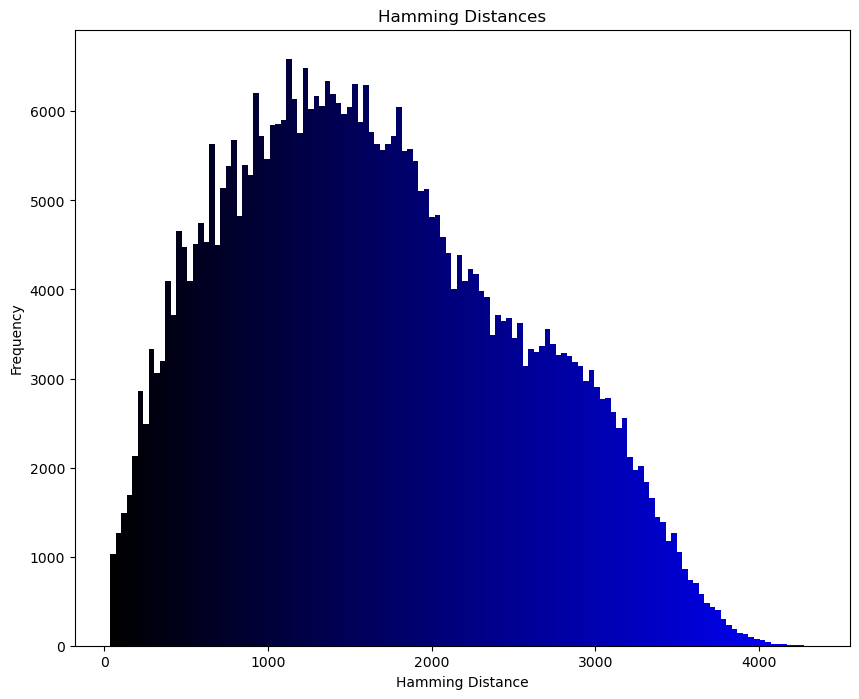

<Figure size 640x480 with 0 Axes>

In [5]:
def plot_hamming_distances(distances: np.ndarray, plts_path: str) -> None:

    plt.figure(figsize=(10, 8), dpi=100)
    _, bins, patches = plt.hist(distances, bins=128)
    
    cmap = mcolors.LinearSegmentedColormap.from_list("black_to_blue", [(0, 0, 0), (0, 0, 1)])
    
    norm = mcolors.Normalize(vmin=bins.min(), vmax=bins.max())
    
    for bin_start, bin_end, patch in zip(bins[:-1], bins[1:], patches):
        color = cmap(norm((bin_start + bin_end) / 2))
        patch.set_facecolor(color)
    
    plt.title('Hamming Distances')
    plt.xlabel('Hamming Distance')
    plt.ylabel('Frequency')
    
    plt.savefig(f"{plts_path}/ham_dists.png", dpi=1200)
    plt.show()
    plt.clf()


plot_hamming_distances(ham_dists, plts_path)

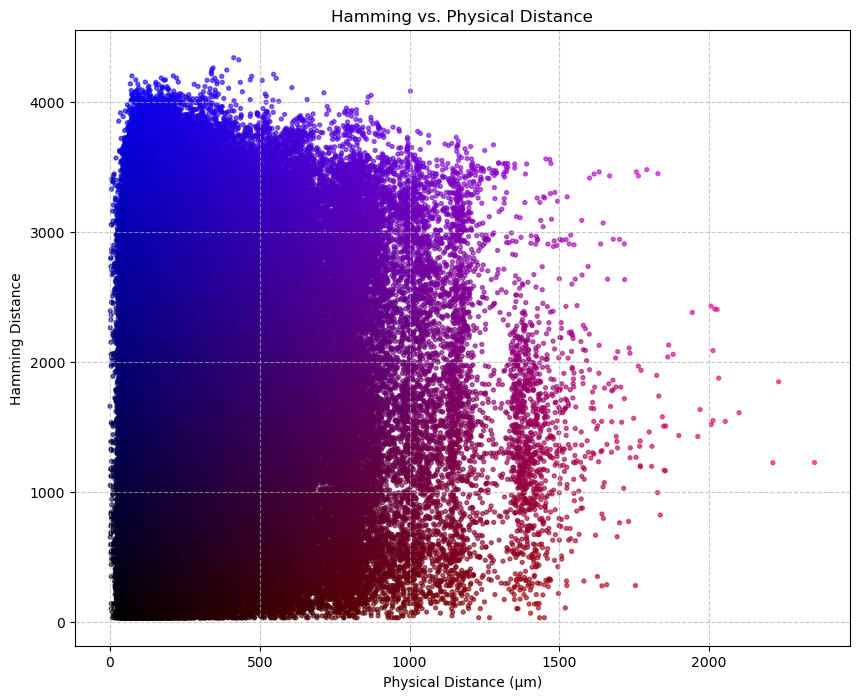

<Figure size 640x480 with 0 Axes>

In [6]:
def ham_and_phys_scat_plot(phys_dists: np.ndarray, ham_dists: np.ndarray, plts_path: str) -> None:
    
    min_length = min(len(phys_dists), len(ham_dists))
    phys_dists = phys_dists[:min_length]
    ham_dists = ham_dists[:min_length]
    
    norm_phys = plt.Normalize(phys_dists.min(), phys_dists.max())
    norm_ham = plt.Normalize(ham_dists.min(), ham_dists.max())

    plt.figure(figsize=(10, 8), dpi=100)
    
    colors = np.zeros((len(phys_dists), 3))
    colors[:, 0] = norm_phys(phys_dists)
    colors[:, 2] = norm_ham(ham_dists)
    
    plt.scatter(phys_dists, ham_dists, c=colors, alpha=0.6, s=8)

    plt.title('Hamming vs. Physical Distance')
    plt.xlabel('Physical Distance (μm)')
    plt.ylabel('Hamming Distance')

    plt.grid(True, linestyle='--', alpha=0.7)

    ax = plt.gca()
    #ax.text(0.05, 0.98, 'Red: High Physical Distance', transform=ax.transAxes, verticalalignment='top', color='red')
    #ax.text(0.35, 0.98, 'Blue: High Hamming Distance', transform=ax.transAxes, verticalalignment='top', color='blue')
    #ax.text(0.65, 0.98, 'Purple/Magenta: High in Both', transform=ax.transAxes, verticalalignment='top', color='purple')

    plt.savefig(os.path.join(plts_path, 'scat_plot.png'), dpi=1200, bbox_inches='tight')
    plt.show()
    plt.clf()


ham_and_phys_scat_plot(phys_dists=phys_dists, ham_dists=ham_dists, plts_path=plts_path)

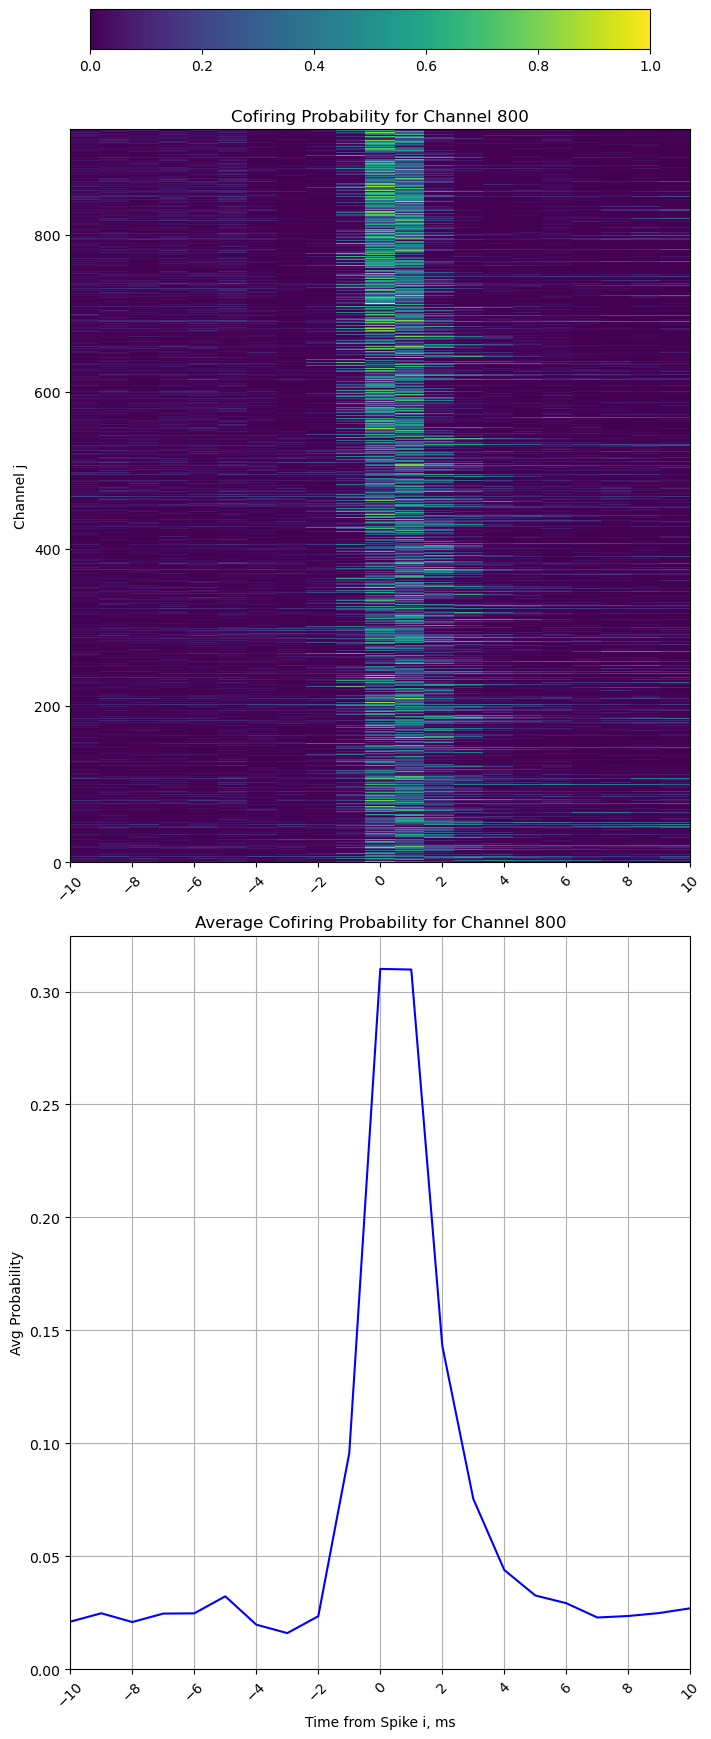

<Figure size 640x480 with 0 Axes>

In [7]:
def cofiring_probability(df: pd.DataFrame, chan_id: int, pre_win: int, post_win: int) -> np.ndarray:
    
    if chan_id not in df.columns:
        raise ValueError(f"Channel {chan_id} not found in DataFrame columns.")
    
    spike_bin = df.to_numpy().T
    num_chan, num_time_bins = spike_bin.shape

    i = df.columns.get_loc(chan_id)

    total_dur = pre_win + post_win + 1
    allall = np.nan * np.ones((num_chan, total_dur))

    wherei = np.where(spike_bin[i, :] == 1)[0]

    if len(wherei) == 0:
        return allall

    for j in range(num_chan):
        wins = np.zeros((len(wherei), total_dur))
        for x, spike_time in enumerate(wherei):
            start_index = max(spike_time - pre_win, 0)
            end_index = min(spike_time + post_win + 1, num_time_bins)
            window_size = end_index - start_index
            wins[x, :window_size] = spike_bin[j, start_index:end_index]
        allall[j, :] = np.sum(wins, axis=0) / len(wherei)

    return allall

def plot_cofiring_prob_one_chan(cofire_matrix: np.ndarray, plts_path: str, chan: int) -> None:

    total_dur = cofire_matrix.shape[1]
    half_dur = (total_dur - 1) // 2
    x_ticks = np.arange(-half_dur, half_dur + 1)
    avg_probability = np.mean(cofire_matrix, axis=0)

    plt.figure(figsize=(8, 20), dpi=100)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)

    ax0 = plt.subplot(gs[0])
    cax = ax0.imshow(cofire_matrix, aspect='auto', cmap='viridis', extent=[x_ticks[0], x_ticks[-1], cofire_matrix.shape[0], 0], interpolation='none')
    cbaxes = plt.gcf().add_axes([0.15, 0.92, 0.7, 0.02])
    plt.colorbar(cax, cax=cbaxes, orientation='horizontal', label='')
    ax0.set_xticks([])
    ax0.set_ylabel('Channel j')
    ax0.set_title(f'Cofiring Probability for Channel {chan}')
    ax0.invert_yaxis()

    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(x_ticks, avg_probability, 'b-')
    ax1.set_ylabel('Avg Probability')
    ax1.set_xlabel('Time from Spike i, ms')
    ax1.set_title(f'Average Cofiring Probability for Channel {chan}')
    slice_step = max(1, len(x_ticks) // 10)
    ax1.set_xticks(x_ticks[::slice_step])
    ax1.set_ylim(0, ax1.get_ylim()[1])
    ax1.grid(True)

    plt.setp(ax0.get_xticklabels(), rotation=45)
    plt.setp(ax1.get_xticklabels(), rotation=45)
    plt.savefig(f"{plts_path}/cofiring_with_avg_vertical", dpi=1200)
    plt.show()
    plt.clf()


chan = 800 #choice(binned_df.columns)
pre_win = 10
post_win = 10

cofire_matrix = cofiring_probability(binned_df, chan, pre_win, post_win)

plot_cofiring_prob_one_chan(cofire_matrix, plts_path, chan)

Calculating avg probs all chans: 100%|██████████| 933/933 [03:58<00:00,  3.92it/s]


            0         1         2         3         4         5         6   \
0     0.031578  0.032320  0.037035  0.039763  0.040500  0.036003  0.031065   
1     0.044893  0.050383  0.059759  0.075499  0.097754  0.113520  0.130495   
2     0.017307  0.012996  0.011311  0.010436  0.013709  0.017080  0.032410   
3     0.033054  0.037456  0.041711  0.046699  0.046507  0.050549  0.050650   
4     0.046799  0.050702  0.049436  0.051006  0.051831  0.051727  0.048303   
...        ...       ...       ...       ...       ...       ...       ...   
1019  0.020321  0.020751  0.027544  0.035919  0.038253  0.028446  0.018751   
1020  0.028799  0.027497  0.028705  0.033499  0.040237  0.039905  0.034540   
1021  0.023241  0.022449  0.024845  0.030567  0.038011  0.035914  0.024620   
1022  0.020284  0.021845  0.021833  0.026283  0.041896  0.038908  0.025865   
1023  0.049840  0.049292  0.048282  0.049865  0.047726  0.033899  0.024548   

            7         8         9   ...        11        12    

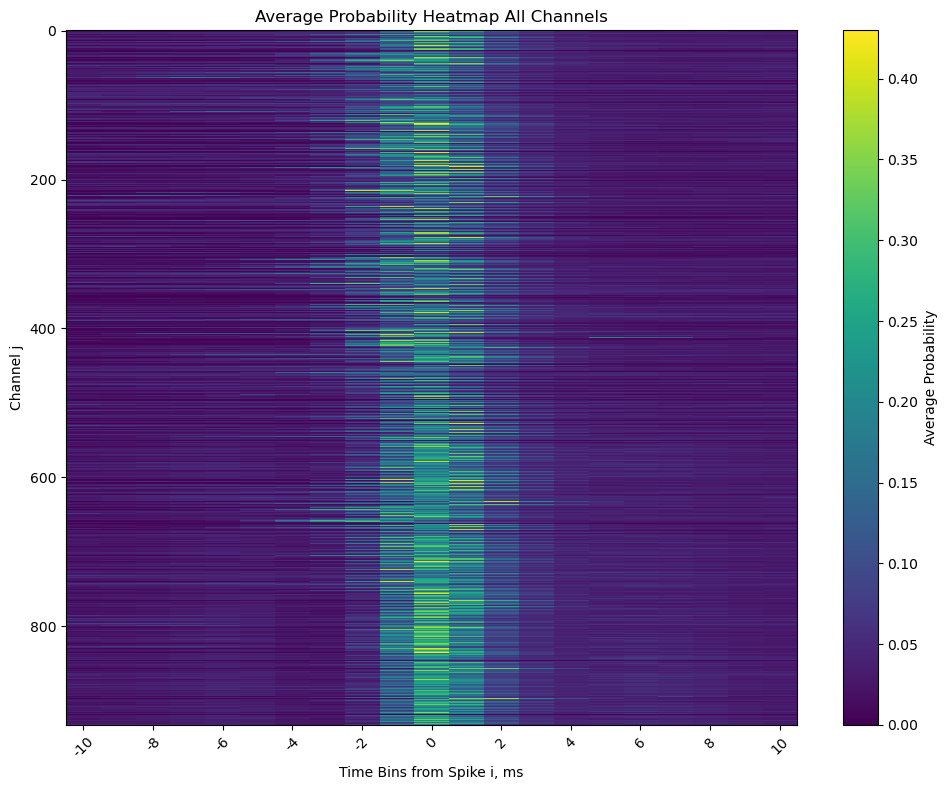

<Figure size 640x480 with 0 Axes>

In [8]:
def calc_avg_probs(binned_df: pd.DataFrame, zero_column_titles: list, pre_win: int, post_win: int) -> pd.DataFrame:
    
    avg_probs_dict = {}
    chan_titles = binned_df.columns

    with tqdm(total=len(chan_titles) - len(zero_column_titles), desc="Calculating avg probs all chans") as pbar:
        for i in chan_titles:
            if i not in zero_column_titles:
                allall = cofiring_probability(df=binned_df, chan_id=i, pre_win=pre_win, post_win=post_win)
                avg_probability = np.mean(allall, axis=0)
                avg_probs_dict[i] = avg_probability
                pbar.update(1)
        pbar.close()

    avg_probs_df = pd.DataFrame.from_dict(avg_probs_dict, orient='index')
    return avg_probs_df

def plot_avg_probs_heatmap_all_chans(avg_probs_df: pd.DataFrame, plts_path: str) -> None:

    total_dur = avg_probs_df.shape[1]
    half_dur = (total_dur - 1) // 2
    x_ticks = np.arange(-half_dur, half_dur + 1)

    slice_step = max(1, len(x_ticks) // 10)

    plt.figure(figsize=(10, 8), dpi=100)
    heatmap = plt.imshow(avg_probs_df.values, aspect='auto', cmap='viridis', interpolation='none')

    plt.colorbar(heatmap, label='Average Probability')

    plt.xticks(np.arange(0, len(x_ticks), slice_step), x_ticks[::slice_step], rotation=45)

    plt.ylabel('Channel j')
    plt.xlabel('Time Bins from Spike i, ms')
    plt.title('Average Probability Heatmap All Channels')

    plt.tight_layout()
    plt.savefig(f"{plts_path}/avg_prob_heatmap_all_chans", dpi=1200)
    plt.show()
    plt.clf()


# these will affect subsequent plots because of avg_probs_df
pre_win = 10
post_win = 10

avg_probs_df = calc_avg_probs(
    binned_df=binned_df,
    zero_column_titles=zero_column_titles,
    pre_win=pre_win,
    post_win=post_win
)

print(avg_probs_df)

plot_avg_probs_heatmap_all_chans(
    avg_probs_df=avg_probs_df,
    plts_path=plts_path
)

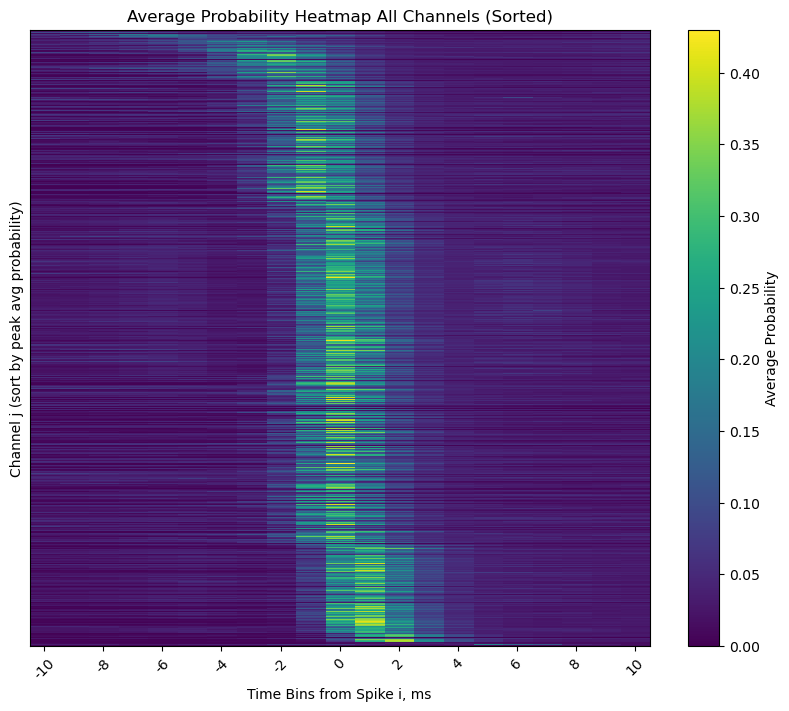

<Figure size 640x480 with 0 Axes>

In [9]:
def calc_peak_binary_matrix(avg_probs_df: pd.DataFrame) -> np.ndarray:
    num_chans, num_time_bins = avg_probs_df.shape
    binary_matrix = np.zeros((num_chans, num_time_bins))

    for i in range(num_chans):
        peak_index = np.argmax(avg_probs_df.iloc[i, :])
        binary_matrix[i, peak_index] = 1

    return binary_matrix

def plot_avg_probs_sort_by_peaks(binary_matrix: np.ndarray, avg_probs_df: pd.DataFrame, plts_path: str) -> None:
    peak_indices = np.argmax(binary_matrix, axis=1)
    sort_indices = np.argsort(peak_indices)
    sort_avg_probs_df = avg_probs_df.iloc[sort_indices, :]
    sort_avg_probs_array = sort_avg_probs_df.to_numpy()

    total_dur = sort_avg_probs_array.shape[1]
    half_dur = (total_dur - 1) // 2
    x_ticks = np.arange(-half_dur, half_dur + 1)
    slice_step = max(1, len(x_ticks) // 10)

    plt.figure(figsize=(10, 8))
    heatmap = plt.imshow(sort_avg_probs_array, aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar(heatmap, label='Average Probability')
    plt.xticks(np.arange(0, len(x_ticks), slice_step), x_ticks[::slice_step], rotation=45)
    plt.yticks([])
    plt.ylabel('Channel j (sort by peak avg probability)')
    plt.xlabel('Time Bins from Spike i, ms')
    plt.title('Average Probability Heatmap All Channels (Sorted)')
    plt.savefig(f"{plts_path}/avg_prob_heatmap_all_chans_sort", dpi=1200)
    plt.show()
    plt.clf()


binary_matrix = calc_peak_binary_matrix(avg_probs_df=avg_probs_df)

plot_avg_probs_sort_by_peaks(
    binary_matrix=binary_matrix,
    avg_probs_df=avg_probs_df,
    plts_path=plts_path
)

           0         1         2         3         4         5         6   \
612  0.002430  0.002363  0.002304  0.002416  0.002526  0.002925  0.002712   
320  0.000869  0.002072  0.000802  0.000869  0.001604  0.002139  0.003543   
428  0.008828  0.008040  0.006771  0.005727  0.004037  0.003671  0.003333   
524  0.016395  0.023651  0.017027  0.013940  0.015374  0.018425  0.020053   
596  0.004564  0.003470  0.003101  0.003297  0.002928  0.002942  0.002686   
..        ...       ...       ...       ...       ...       ...       ...   
327  0.011116  0.011682  0.012322  0.018036  0.023173  0.025330  0.032597   
447  0.002701  0.003607  0.009154  0.009299  0.007015  0.006127  0.015662   
499  0.003274  0.002847  0.002945  0.003817  0.004179  0.005496  0.012143   
339  0.022703  0.023891  0.029474  0.035582  0.060926  0.117035  0.195456   
375  0.014525  0.013212  0.014321  0.019975  0.027084  0.044188  0.099308   

           7         8         9   ...        11        12        13  \
612

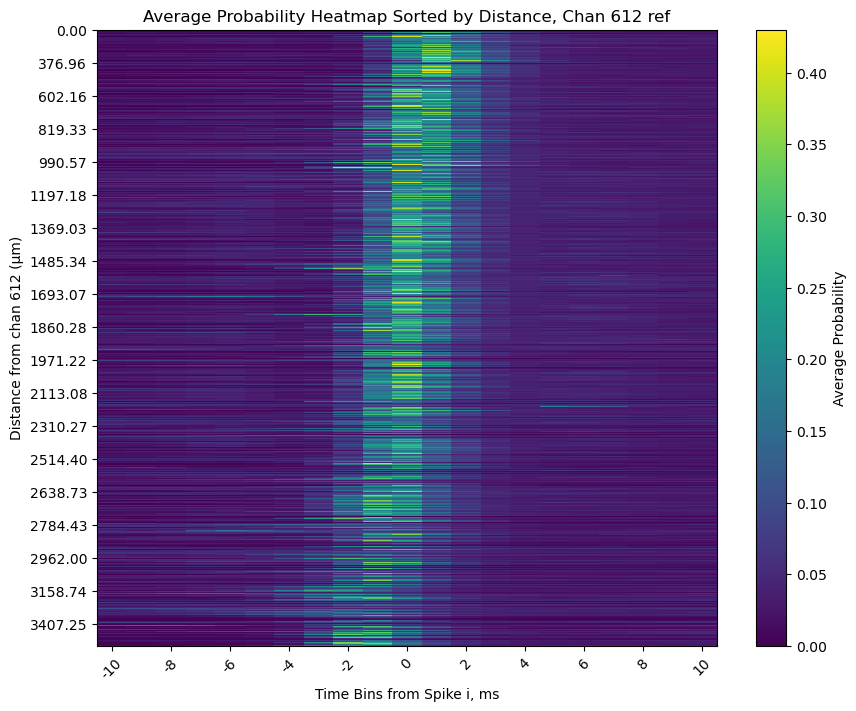

<Figure size 640x480 with 0 Axes>

In [10]:
def sort_avg_probs_by_phys_dist(binned_df: pd.DataFrame, zero_column_titles: list, mapping: pd.DataFrame, avg_probs_df: pd.DataFrame, ref_chan: int) -> Tuple[pd.DataFrame, list]:
    
    chan_positions = mapping.set_index('channel')[['x', 'y']].to_dict('index')
    ref_coords = (chan_positions[ref_chan]['x'], chan_positions[ref_chan]['y'])
    chan_titles = [chan for chan in binned_df.columns if chan not in zero_column_titles]
    physical_distances = {chan: euclidean((chan_positions[chan]['x'], chan_positions[chan]['y']), ref_coords) for chan in chan_titles}
    
    sort_chans = sorted(physical_distances, key=physical_distances.get)
    sort_distances = [physical_distances[chan] for chan in sort_chans]
    
    sort_indices = [chan_titles.index(chan) for chan in sort_chans]
    
    sort_avg_probs_df = avg_probs_df.iloc[sort_indices, :]
    
    return sort_avg_probs_df, sort_distances

def plot_avg_probs_heatmap_sort_by_phys_dist(sort_avg_probs_df: pd.DataFrame, distances: list, plts_path: str, ref_chan: int) -> None:

    sort_avg_probs_array = sort_avg_probs_df.to_numpy()

    total_dur = sort_avg_probs_array.shape[1]
    half_dur = (total_dur - 1) // 2
    x_ticks = np.arange(-half_dur, half_dur + 1)
    slice_step = max(1, len(x_ticks) // 10)

    plt.figure(figsize=(10, 8), dpi=100)
    heatmap = plt.imshow(sort_avg_probs_array, aspect='auto', cmap='viridis', interpolation='none')

    plt.colorbar(heatmap, label='Average Probability')

    plt.xticks(np.arange(0, len(x_ticks), slice_step), x_ticks[::slice_step], rotation=45)
    
    y_ticks = np.arange(0, len(distances), 50)
    y_labels = [f"{distances[i]:.2f}" for i in y_ticks]
    plt.yticks(y_ticks, y_labels)

    plt.ylabel(f'Distance from chan {ref_chan} (μm)')
    plt.xlabel('Time Bins from Spike i, ms')
    plt.title(f'Average Probability Heatmap Sorted by Distance, Chan {ref_chan} ref')

    plt.savefig(f"{plts_path}/avg_prob_heatmap_sort_by_dist.png", dpi=1200)
    plt.show()
    plt.clf()


ref_chan = 612 # choice(binned_df.columns)

sort_avg_probs_df, sort_distances = sort_avg_probs_by_phys_dist(
    binned_df=binned_df,
    zero_column_titles=zero_column_titles,
    mapping=mapping_pd_df,
    avg_probs_df=avg_probs_df,
    ref_chan=ref_chan
)

print(sort_avg_probs_df)

plot_avg_probs_heatmap_sort_by_phys_dist(
    sort_avg_probs_df=sort_avg_probs_df,
    distances=sort_distances,
    plts_path=plts_path,
    ref_chan=ref_chan,
)

In [11]:
def calc_cofire_integrals(avg_probs_df: pd.DataFrame, mapping: pd.DataFrame) -> pd.DataFrame:
    total_dur = avg_probs_df.shape[1]
    half_dur = (total_dur - 1) // 2
    time_bins = np.arange(-half_dur, half_dur + 1)

    integrals = avg_probs_df.values @ time_bins

    status = np.where(integrals < 0, "inhibitory", "excitatory")

    results_df = pd.DataFrame({
        'channel': avg_probs_df.index,
        'integral': integrals,
        'status': status
    })

    results_df = results_df.merge(mapping, left_on='channel', right_on='channel')

    return results_df

results_df = calc_cofire_integrals(avg_probs_df, mapping_pd_df)

sorted_results_df = results_df.sort_values(by='integral')

inhibitory_count = (sorted_results_df['status'] == "inhibitory").sum()
excitatory_count = (sorted_results_df['status'] == "excitatory").sum()

output_data_path = f"{plts_path}/integrals.txt"
with open(output_data_path, 'w') as file:
    for _, row in sorted_results_df.iterrows():
        output_line = f"Channel: {row['channel']}, Electrode: {row['electrode']}, X: {row['x']}, Y: {row['y']}, Status: {row['status']}, Integral: {row['integral']}"
        print(output_line.strip())
        file.write(output_line + '\n')
    output_line_2 = f"Total inhibitory: {inhibitory_count}, Total excitatory: {excitatory_count}"
    print(output_line_2)
    file.write(output_line_2)

Channel: 654, Electrode: 21847, X: 1172.5, Y: 1732.5, Status: inhibitory, Integral: -4.542688194158781
Channel: 63, Electrode: 17587, X: 3622.5, Y: 1382.5, Status: inhibitory, Integral: -3.908518622760145
Channel: 279, Electrode: 20675, X: 3762.5, Y: 1627.5, Status: inhibitory, Integral: -3.706050516261411
Channel: 429, Electrode: 4389, X: 3657.5, Y: 332.5, Status: inhibitory, Integral: -3.4535703051274
Channel: 227, Electrode: 21115, X: 3762.5, Y: 1662.5, Status: inhibitory, Integral: -3.1617175212330944
Channel: 477, Electrode: 3951, X: 3692.5, Y: 297.5, Status: inhibitory, Integral: -2.8566510695187177
Channel: 389, Electrode: 6999, X: 3132.5, Y: 542.5, Status: inhibitory, Integral: -2.790752503914679
Channel: 109, Electrode: 9657, X: 3447.5, Y: 752.5, Status: inhibitory, Integral: -2.679602750190968
Channel: 527, Electrode: 22861, X: 3517.5, Y: 1802.5, Status: inhibitory, Integral: -2.431505202503828
Channel: 437, Electrode: 431, X: 3692.5, Y: 17.5, Status: inhibitory, Integral: -2

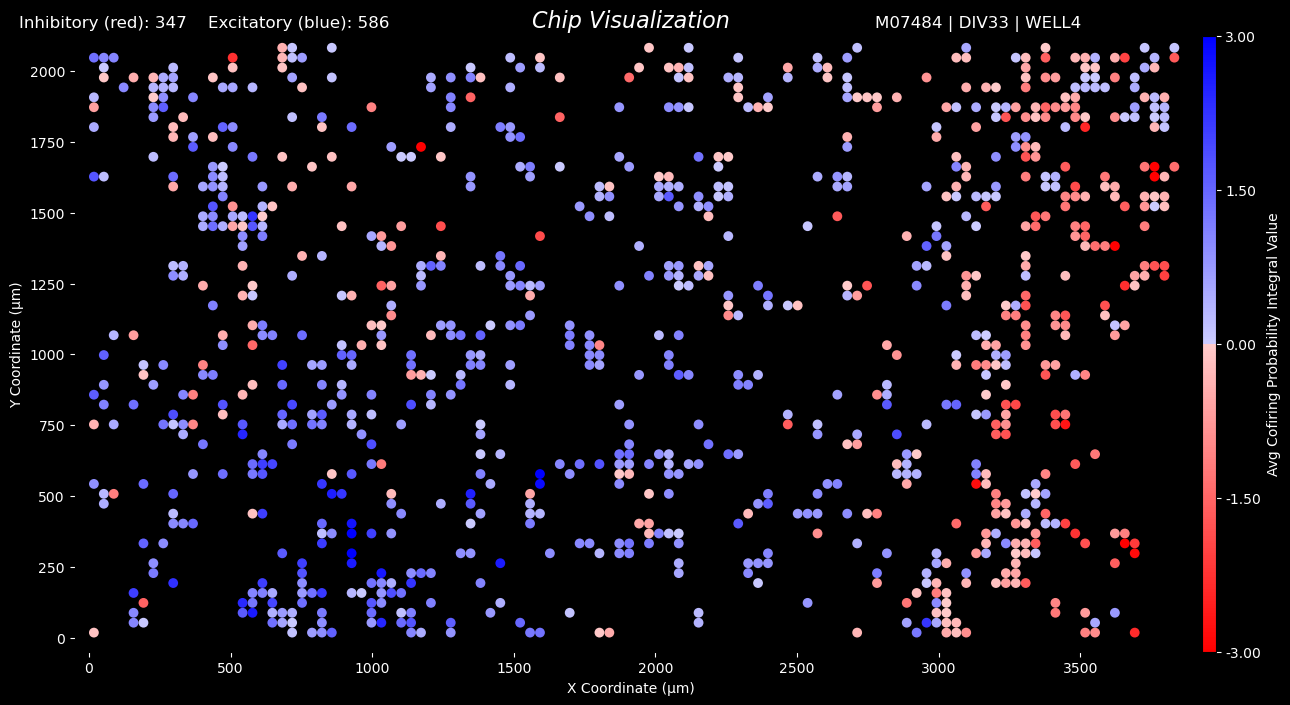

<Figure size 640x480 with 0 Axes>

In [12]:
def plot_chip_visualization(results_df: pd.DataFrame, plts_path: str, chip_div_well: str) -> None:
    
    x_coords = results_df['x']
    y_coords = results_df['y']
    integral_values = results_df['integral']

    norm = plt.Normalize(vmin=-3, vmax=3)
    
    colors = [(1, 0, 0), (1, 0.8, 0.8), (0.8, 0.8, 1), (0, 0, 1)]
    positions = [0, 0.5, 0.5, 1]
    cmap = LinearSegmentedColormap.from_list("custom_red_blue", list(zip(positions, colors)))

    plt.figure(figsize=(20, 8), facecolor='black')
    scatter = plt.scatter(x_coords, y_coords, c=integral_values, cmap=cmap, s=50, alpha=1, edgecolors='none', norm=norm)

    cbar = plt.colorbar(scatter, pad=0.01, aspect=45)
    cbar.set_label('Avg Cofiring Probability Integral Value', color='white')

    cbar.set_ticks(np.linspace(-3, 3, num=5))
    cbar.set_ticklabels([f'{x:.2f}' for x in np.linspace(-3, 3, num=5)])
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.ax.yaxis.set_tick_params(labelcolor='white')

    plt.xlabel('X Coordinate (µm)', color='white')
    plt.ylabel('Y Coordinate (µm)', color='white')
    plt.title('Chip Visualization', color='white', fontsize=16, fontstyle='italic')

    plt.gca().set_facecolor('black')
    plt.gca().tick_params(colors='white')

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim(-50, 3875)
    plt.ylim(-50, 2125)

    inhibitory_count = (results_df['status'] == "inhibitory").sum()
    excitatory_count = (results_df['status'] == "excitatory").sum()

    plt.text(-0.05, 1.0322, f'Inhibitory (red): {inhibitory_count}', transform=plt.gca().transAxes, color='white', fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.text(0.12, 1.0322, f'Excitatory (blue): {excitatory_count}', transform=plt.gca().transAxes, color='white', fontsize=12, verticalalignment='top', horizontalalignment='left')

    plt.text(0.72, 1.0322, chip_div_well, transform=plt.gca().transAxes, color='white', fontsize=12, verticalalignment='top', horizontalalignment='left')

    plt.savefig(f"{plts_path}/chip_vis.png", dpi=1200, bbox_inches='tight')
    
    plt.show()
    plt.clf()

plot_chip_visualization(results_df, plts_path, chip_div_well=chip_div_well)